In [1]:
import numpy as np
import pandas as pd
import re
%cd /cluster/home/futing/Project/GBM/HiC/HAR/HARs_gene
genedir='/cluster/home/futing/Project/GBM/HiC/HAR/HARs_gene/genes'

/cluster/home/futing/Project/GBM/HiC/HAR/HARs_gene


### 预处理，获得HARs调控的基因	
* 调试用，实际运行为/cluster/home/futing/Project/GBM/HiC/HAR/HARs_gene/genes/filHARsgene.py

In [2]:
GBM=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/HAR/loopbedpe/GBM_HARs.bedpe',sep='\t')
GBM['HAR']=GBM['chr_H']+'_'+GBM['start_H'].astype(str)+'_'+GBM['end_H'].astype(str)

In [3]:
# 挑选EPloop 并判断是否是Enhancer
GBM_EP=GBM.loc[GBM['E-P']==1,:]
GBM_EP.loc[:,'EHAR']=0
def is_exponential(value):
    return bool(re.fullmatch(r"^E\d+$", str(value)))
bin1_mask = GBM_EP["bin1"].astype(str).str.match(r"^E\d+$")
bin2_mask = GBM_EP["bin2"].astype(str).str.match(r"^E\d+$")

GBM_EP.loc[bin1_mask & ((GBM_EP["start1"] <= GBM_EP["end_H"]) & 
                      (GBM_EP["start_H"] <= GBM_EP["end1"])).astype(int),'EHAR']=1
GBM_EP.loc[bin2_mask & ((GBM_EP["start2"] <= GBM_EP["end_H"]) & 
                      (GBM_EP["start_H"] <= GBM_EP["end2"])).astype(int),'EHAR']=1	

/tmp/ipykernel_111721/3320904052.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GBM_EP.loc[:,'EHAR']=0


In [ ]:
# 保证一个loop只有一个unique HAR，忽略不同的Enhancer
GBM_EPs=GBM_EP.drop(columns=['bin1','bin2','E-E','E-P','P-P','other']).drop_duplicates()

#### HARs 是否是 Enhancer

In [5]:
# 查看是否是looped Enhancer
HARs_count=GBM_EPs.loc[:,['HAR','EHAR']].drop_duplicates()

In [6]:
HARs_count['EHAR'].value_counts()

EHAR
1    116
0     76
Name: count, dtype: int64

In [7]:
HARs_count.to_csv('HARs_count.csv',sep='\t')

#### 寻找HARs调控基因

In [11]:
HARs_gene=GBM_EPs.loc[GBM_EPs['EHAR']==1,['gene','chr_H','start_H','end_H','HAR']].drop_duplicates()

In [14]:
HARs_gene.to_csv('/cluster/home/futing/Project/GBM/HiC/HAR/loopbedpe/GBM_HARsgene.txt',sep='\t')

## 筛选合并的基因信息	
*	来源于concat3.py HARs_gene.txt

In [2]:
HARs_gene=pd.read_csv(f'{genedir}/all/HARs_gene.txt',sep='\t')
HARs_gene_long = HARs_gene.melt(id_vars=['HAR'], value_vars=['GBM', 'NPC', 'iPSC', 'NHA'], 
	var_name='CellType', value_name='Gene')
HARs_gene_long = HARs_gene_long.dropna()

In [12]:
HARs_gene['HAR'].nunique(),HARs_gene.shape

(210, (537, 5))

### 按照组内数量筛选

In [14]:
# method 1 筛选仅有一个基因的HAR
# 寻找每组HAR中gene不唯一的 HAR，去除了只有一个基因的HAR和重复的HAR
filter_HARs=HARs_gene_long.groupby('HAR').filter(lambda x: x['Gene'].nunique()>1)
# filter_HARs.to_csv(f'{genedir}/long/HARsgene_ununiq.txt',sep='\t',index=False)

print(f'all HARs_gene_long is {HARs_gene_long.shape}, ununiq HARs num is{filter_HARs.shape}')
print(f'filter HARs number: {filter_HARs.loc[filter_HARs.loc[:,"CellType"]=="GBM","HAR"].nunique()}')

all HARs_gene_long is (657, 3), ununiq HARs num is(573, 3)
filter HARs number: 85


In [18]:
# method 2 筛选在GBM中特异调控的HAR，即查找每个样本中的HAR调控的基因是否一致
def difgene(df):

	GBM_genes = df.loc[df['CellType'] == 'GBM', 'Gene'].unique()
	other_genes = df.loc[df['CellType'] != 'GBM', 'Gene'].unique()

	# 如果两组基因不同，返回 1；否则返回 0
	if set(GBM_genes) != set(other_genes):
		if len(set(GBM_genes)) > len(set(other_genes)):
			return 2
		else:
			return 1
	else:
		return 0

# 差异的HAR index
# GBM_diff = filter_HARs.groupby('HAR').apply(difgene) 
GBM_diff = HARs_gene_long.groupby('HAR').apply(difgene)

# filter_HARs 矩阵筛选
filter_HARs_GBM=HARs_gene_long.loc[HARs_gene_long['HAR'].isin(GBM_diff[GBM_diff!=0].index),:]
print(f'HARs with diff-regulated groups in GBMvsctrl is {filter_HARs_GBM.loc[:,"HAR"].nunique()}')

HARs with diff-regulated groups in GBMvsctrl is 199


/tmp/ipykernel_9937/3584049401.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  GBM_diff = HARs_gene_long.groupby('HAR').apply(difgene)


In [4]:
# 按照调控基因不同筛选
# filter_HARs_GBM.to_csv(f'{genedir}/long/GBMvsNHA/HARsgene_GBMvsNHA_bygene.txt',sep='\t',index=False)
filter_HARs_GBM = pd.read_csv(f'{genedir}/long/GBMvsNHA/HARsgene_GBMvsNHA_bygene.txt',sep='\t')

### 特异性调控筛选	
* 来源于 step4:fil_specific_genes.ipynb 这个文件

In [5]:

NHA_sgene=pd.read_csv(f'{genedir}/long/sGBMvsNHA/NHA_specific_enhancer_gene.txt',sep='\t',header=None)
GBM_sgene=pd.read_csv(f'{genedir}/long/sGBMvsNHA/GBM_specific_enhancer_gene.txt',sep='\t',header=None)
GBMvsNHA_bygene=pd.concat([NHA_sgene,GBM_sgene],axis=0)
GBMvsNHA_bygene.columns=['HAR','Gene','Cell']
# GBMvsNHA_bygene.to_csv(f'{genedir}/long/GBMvsNHA/HARsgene_sGBMvsNHA_bygene.txt',sep='\t',index=False)

In [6]:
NPC_sgene=pd.read_csv(f'{genedir}/long/sGBMvsNPC/NPC_specific_enhancer_gene.txt',sep='\t',header=None)
GBM_sgene=pd.read_csv(f'{genedir}/long/sGBMvsNPC/GBM_specific_enhancer_gene.txt',sep='\t',header=None)
GBMvsNPC_bygene=pd.concat([NPC_sgene,GBM_sgene],axis=0)
GBMvsNPC_bygene.columns=['HAR','Gene','Cell']
# GBMvsNPC_bygene.to_csv(f'{genedir}/long/sGBMvsNPC/HARsgene_sGBMvsNPC_bygene.txt',sep='\t',index=False)

### 用RNA表达进行筛选

In [9]:
Deseq=pd.read_csv(f'{genedir}/RNADESeq2/NHA_vs_GBM_symbol.txt',sep='\t')

Deseq_sig=Deseq.loc[(Deseq['padj']<0.05) & (abs(Deseq['log2FoldChange'])>1),:]
# Deseq_sig['biomart'].to_csv(f'{genedir}/RNADESeq2/NPC_vs_GBM_sig.txt',sep='\t',index=False)
print(f'Number of Diff genes: {len(Deseq_sig)}')

Number of Diff genes: 8740


In [10]:
# 01 筛选 HARs-regulated genes groups 不同的HARs

name='GBMvsNPC'
filmatrix=filter_HARs_GBM # HARs_gene_long #  
HARs_gene_RNAfilbygene=filmatrix.loc[filmatrix['Gene'].isin(Deseq_sig['biomart']),:] #用所有的话有141个，先选择调控不同+基因差异90个
# HARs_gene_RNAfilbygene.to_csv(f'{genedir}/long/{name}/HARsgene_{name}_bygeneRNA.txt',sep='\t',index=False)
print(f'Num of HARs with diff-groups and diff-expressed genes is {HARs_gene_RNAfilbygene.shape}')

filmatrix=HARs_gene_long #  所有的基因
HARs_gene_RNAfil=filmatrix.loc[filmatrix['Gene'].isin(Deseq_sig['biomart']),:] #用所有的话有141个，先选择调控不同+基因差异90个
# HARs_gene_RNAfil.to_csv(f'{genedir}/long/{name}/HARsgene_{name}_RNA.txt',sep='\t',index=False)
print(f'Num of HARs with diff-expressed genes is {HARs_gene_RNAfil.shape}')

Num of HARs with diff-groups and diff-expressed genes is (90, 3)
Num of HARs with diff-expressed genes is (141, 3)


In [17]:
# 02 筛选 E-P 不同对应的 HARs
name='GBMvsNHA'
filmatrix=GBMvsNHA_bygene #  所有的基因

HARs_gene_RNAfil=filmatrix.loc[filmatrix['Gene'].isin(Deseq_sig['biomart']),:] #64个GBMvsNHA 94GBMvsNPC
# HARs_gene_RNAfil.to_csv(f'{genedir}/long/s{name}/HARsgene_s{name}_bygeneRNA.txt',sep='\t',index=False)
print(HARs_gene_RNAfil.shape)

(64, 3)


## 获得互作区域	
*	绘图区域获得 HAR gene的最大区域，输出至 ./genes/HARregion_GBM.txt

In [7]:

# filgene=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/HAR/HARs_gene/genes/filter_HARs_gene.txt',sep='\t')
RNA_bed=pd.read_csv('/cluster/home/futing/ref_genome/hg38_gencode/genebed/gencode.v43.gene.bed',sep='\t',header=None)
# RNA_bed=RNA_bed.loc[RNA_bed[8]!='ncRNA',:]
RNA_bed=RNA_bed.iloc[:,[0,1,2,6,8]]

In [8]:
def find_max_interval(row):
	start=max((min(int(row[1]),int(row['start'])) -10000),0)
	end=max(int(row[2]),int(row['end'])) +10000
	return pd.Series([start,end],index=['start_max','end_max'])

In [26]:
# 定义输入 HAR 与调控基因
filgene=GBMvsNHA_bygene
# filgene=HARs_gene_RNAfilbygene
# filgene = HARs_gene_RNAfil
print(f'Num of HARs: {filgene["HAR"].nunique()}')
filgene.head()

Num of HARs: 130


,HAR,Gene,Cell
0,chr10_24728545_24728698,LINC01516,NHA
1,chr10_24728545_24728698,RNA5SP305,NHA
2,chr10_24728545_24728698,THNSL1,NHA
3,chr11_28117600_28117973,BDNF,NHA
4,chr11_3831846_3832042,ENSG00000255232,NHA


In [27]:
# 合并 RNA 基因组区间和 HARs 基因组区间
filgene_anno=pd.merge(filgene,RNA_bed,left_on='Gene',right_on=6,how='left')
filgene_anno[['chr','start','end']]=filgene_anno['HAR'].str.split('_',expand=True)
# 同一HARs最大的互作区间
fil_gene_max=filgene_anno.apply(find_max_interval,axis=1)
fil_gene_max=pd.concat([filgene_anno,fil_gene_max],axis=1)
fil_gene_max=fil_gene_max.loc[fil_gene_max['Gene']!='Y_RNA',:]

# Group by HAR and aggregate
HARregion = fil_gene_max.groupby('HAR').agg({
    'chr': 'first',
    'start_max': 'min',
    'end_max': 'max',
    'Gene': lambda x: ', '.join(sorted(set(x.dropna())))  # Add this line for regulated genes
}).rename(columns={'Gene': 'regulated_genes'})  # Rename the new column

# Reset index to make HAR a column again if needed
HARregion = HARregion.reset_index()

In [28]:
HARregion.head()

,HAR,chr,start_max,end_max,regulated_genes
0,chr10_24728545_24728698,chr10,24630165,25702323,"ENSG00000228667, ENSG00000273107, ENSG00000285..."
1,chr10_8049676_8049703,chr10,7523206,8059703,ENSG00000230121
2,chr11_10321139_10321494,chr11,8683350,10331494,"AKIP1, DENND2B"
3,chr11_12329873_12330103,chr11,12319873,12954737,"ENSG00000252329, TEAD1"
4,chr11_125350738_125350752,chr11,125340738,125910646,"ENSG00000260209, HYLS1"


In [29]:
name='GBMvsNHA'
HARregion.to_csv(f'{genedir}/HARregion/{name}/HARregion_{name}_bygenes.txt',sep='\t')

# process others

In [1]:
import cooler
import pandas as pd
import sys

In [2]:
name='NPC_merge'


In [5]:
c = cooler.Cooler(f'/cluster/home/futing/Project/GBM/HiC/02data/03cool_order/10000/{name}_nodiag_10000.cool')



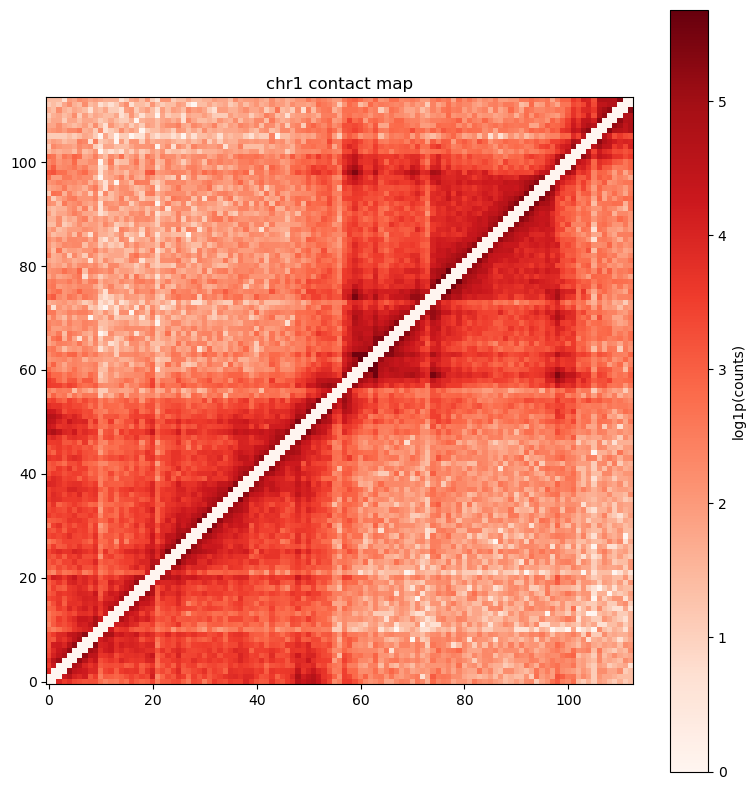

In [7]:
import matplotlib.pyplot as plt
import numpy as np

chrom = "chr1"     # 可改为你感兴趣的染色体
region = "chr12:3290697-4415490"      # 或例如 "chr1:0-10000000" 限定区域



# 读取矩阵（整个染色体或指定区域）
if region:
    matrix = c.matrix(balance=False).fetch(region)
else:
    matrix = c.matrix(balance=False).fetch(chrom)

# 画图
plt.figure(figsize=(8, 8))
plt.imshow(np.log1p(matrix), cmap='Reds', origin='lower')
plt.title(f"{chrom} contact map")
plt.colorbar(label="log1p(counts)")
plt.tight_layout()
plt.show()